Author: Darian Hadjiabadi | CS231N Final project

This notebook is for testing the various types of GAN (vanilla, LS, DG)
on a small dataset. Results are not expected to look good at all. 

In [3]:
import numpy as np
import sys
import os

import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

from gan.network_utils import run_a_gan
from gan.network_utils import show_images
from gan.network_utils import initialize_weights
from gan.network_utils import count_params
from gan.network import discriminator
from gan.network import dc_discriminator
from gan.network import vanilla_discriminator_loss
from gan.network import ls_discriminator_loss
from gan.network import generator
from gan.network import dc_generator
from gan.network import vanilla_generator_loss
from gan.network import ls_generator_loss

from gan.network import get_optimizer


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


done


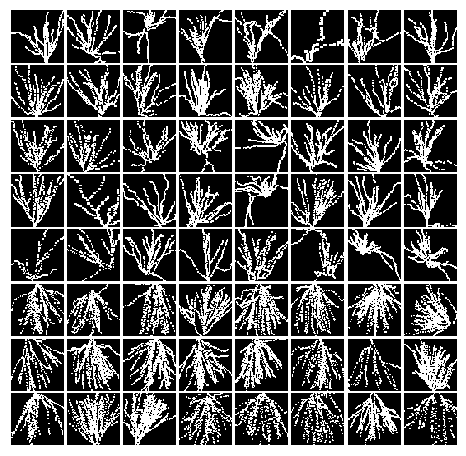

In [4]:
# ChunkSampler class taken from assignment3/GANs-PyTorch.ipynb

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples


NUM_TRAIN = 400
batch_size = 64
neuron_train = dset.ImageFolder('./database-imgs-small/', transform=T.ToTensor())
loader_train = DataLoader(neuron_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))


imgs = loader_train.__iter__().next()[0][:,0,:,:].view(batch_size, -1).numpy().squeeze()
show_images(imgs)
print('done')
# Let's view some neurons!


Iter: 0, D: 1.294, G:0.7336


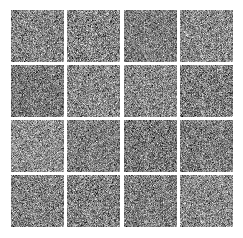


Iter: 100, D: 1.385, G:1.521


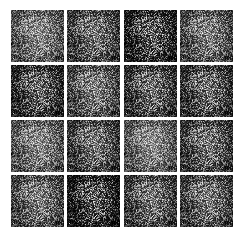


Iter: 200, D: 1.48, G:1.129


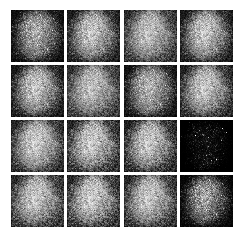


Iter: 300, D: 1.29, G:0.8356


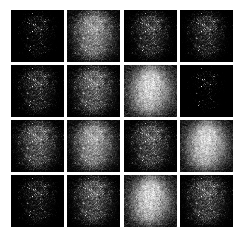


Iter: 400, D: 1.2, G:1.948


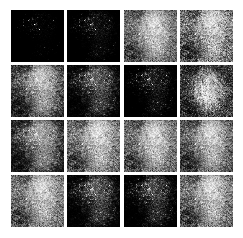


Iter: 500, D: 1.073, G:0.9396


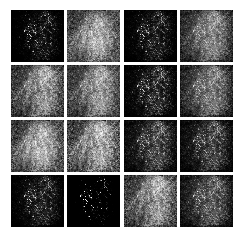


Iter: 600, D: 1.369, G:1.194


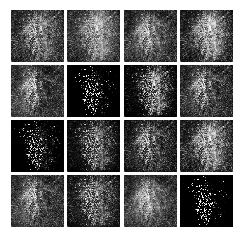


Iter: 700, D: 1.307, G:0.8006


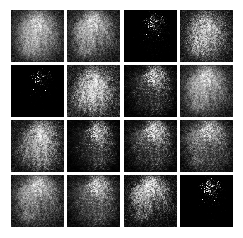


Iter: 800, D: 1.257, G:0.9475


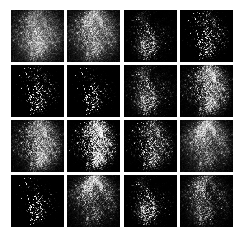


Iter: 900, D: 1.899, G:0.7413


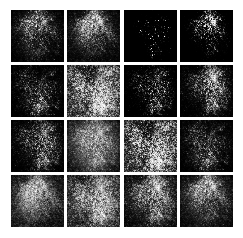


Iter: 1000, D: 1.363, G:1.932


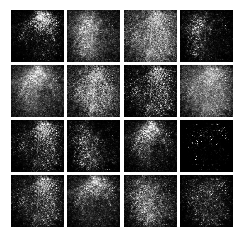


Iter: 1100, D: 0.9473, G:2.15


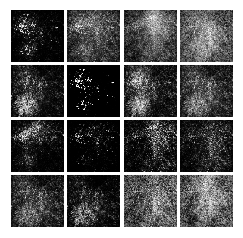


Run complete


In [10]:

def vanilla_gan_run(dtype, lr, beta1, beta2):
    # Make the discriminator
    D = discriminator().type(dtype)
    # Make the generator
    G = generator().type(dtype)

    # Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
    D_solver = get_optimizer(D, lr=lr, beta1=beta1, beta2=beta2)
    G_solver = get_optimizer(G, lr=lr, beta1=beta1, beta2=beta2)
    # Run it!
    d_loss_list, g_loss_list, fake_imgs = run_a_gan(loader_train, dtype, D, G, D_solver, G_solver, vanilla_discriminator_loss, vanilla_generator_loss,num_epochs=200)
    return d_loss_list, g_loss_list, fake_imgs

dtype = torch.FloatTensor
d_loss_list, g_loss_list, fake_imgs = vanilla_gan_run(dtype, 1.0e-3, 0.50, 0.999)
print('Run complete')

In [5]:

def plot_loss(d_list, g_list):
    fig = plt.figure()
    t = np.arange(len(d_list))
    plt.plot(t, d_list,'r')
    plt.plot(t, g_list,'b')
    plt.legend(['Discriminator loss', 'Generator loss'])


# save images to output directory
def count_to_str(count):
    if count < 10:
        return '00000' + str(count)
    elif count >= 10 and count < 100:
        return '0000' + str(count)
    elif count >= 100 and count < 1000:
        return '000' + str(count)
    elif count >= 1000 and count < 10000:
        return '00' + str(count)
    elif count >= 10000 and count < 100000:
        return '0' + str(count)
    
def save_imgs(imgs, dir_path):
    import scipy.misc
    imgs = np.reshape(fake_imgs, [imgs.shape[0], -1])
    sqrtimg = int(np.ceil(np.sqrt(imgs.shape[1])))
    imgs = np.reshape(imgs, (imgs.shape[0], sqrtimg, sqrtimg))
    
    for i in range(imgs.shape[0]):
        nstr = count_to_str(i)
        fn_full = 'img-' + nstr + '.png'
        scipy.misc.imsave(dir_path + fn_full, imgs[i,:,:])        



/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


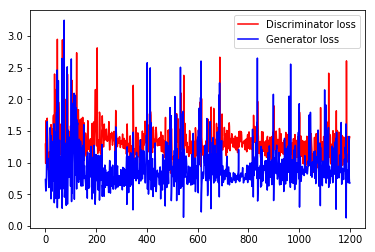

In [12]:
# Plot discriminator and generator loss for vanilla GAN

plot_loss(d_loss_list, g_loss_list)      
dir_path = 'output-small/vanilla/'
save_imgs(fake_imgs, dir_path)


Iter: 0, D: 0.5566, G:0.4288


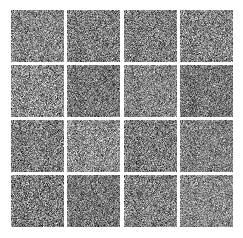


Iter: 100, D: 0.3403, G:0.7849


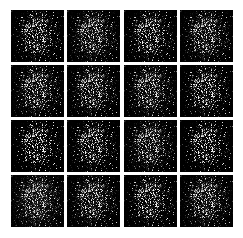


Iter: 200, D: 0.3176, G:0.1625


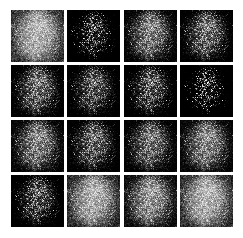


Iter: 300, D: 0.2693, G:0.1744


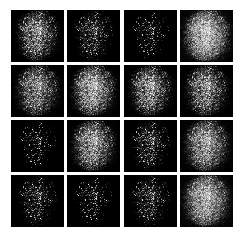


Iter: 400, D: 0.2712, G:0.1216


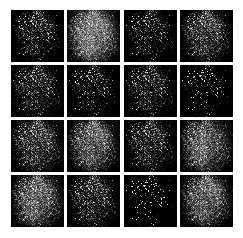


Iter: 500, D: 0.1522, G:0.268


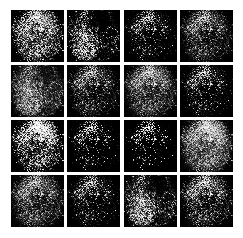


Iter: 600, D: 0.2192, G:0.1758


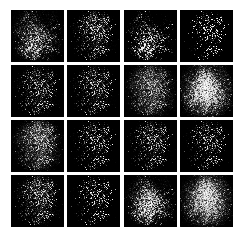


Iter: 700, D: 0.4898, G:0.1977


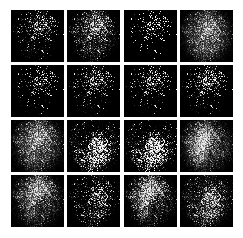


Iter: 800, D: 0.2383, G:0.2025


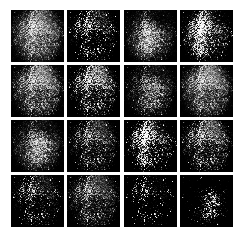


Iter: 900, D: 0.2007, G:0.2416


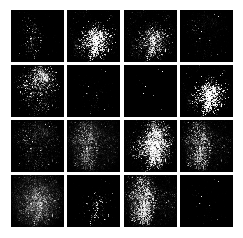


Iter: 1000, D: 0.2096, G:0.1615


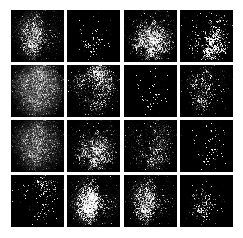


Iter: 1100, D: 0.208, G:0.2234


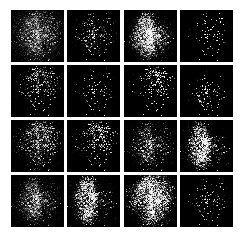


Run complete


In [13]:
def ls_gan_run(dtype, lr, beta1, beta2):
    # Make the discriminator
    D = discriminator().type(dtype)
    # Make the generator
    G = generator().type(dtype)

    # Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
    D_solver = get_optimizer(D, lr=lr, beta1=beta1, beta2=beta2)
    G_solver = get_optimizer(G, lr=lr, beta1=beta1, beta2=beta2)
    # Run it!
    d_loss_list, g_loss_list, fake_imgs = run_a_gan(loader_train, dtype, D, G, D_solver, G_solver, ls_discriminator_loss, ls_generator_loss,num_epochs=200)
    return d_loss_list, g_loss_list, fake_imgs

dtype = torch.FloatTensor
d_loss_list, g_loss_list, fake_imgs = ls_gan_run(dtype, 1e-3, 0.50, 0.999)
print('Run complete')

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


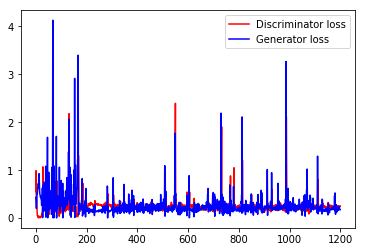

In [14]:
# Plot discriminator and generator loss for LS-GAN


dir_path = 'output-small/ls/'
save_imgs(fake_imgs, dir_path)
plot_loss(d_loss_list, g_loss_list)


Iter: 0, D: 1.342, G:0.04008


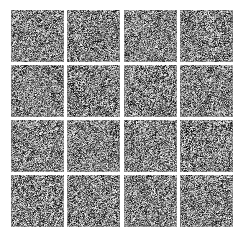


Iter: 100, D: 0.5327, G:1.479


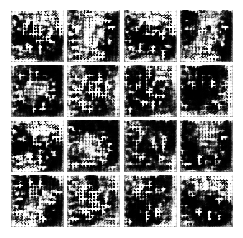


Iter: 200, D: 1.192, G:0.9062


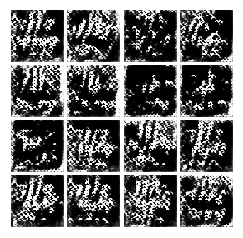


Run complete


In [3]:
def dg_gan_run(batch_size, dtype, lr, beta1, beta2):


    D_DC = dc_discriminator(batch_size).type(dtype) 
    D_DC.apply(initialize_weights)
    G_DC = dc_generator(batch_size).type(dtype)
    G_DC.apply(initialize_weights)

    D_DC_solver = get_optimizer(D_DC, lr=lr, beta1=beta1, beta2=beta2)
    G_DC_solver = get_optimizer(G_DC, lr=lr, beta1=beta1, beta2=beta2)
    d_loss_list, g_loss_list, fake_imgs = run_a_gan(loader_train, dtype, D_DC, G_DC, D_DC_solver, G_DC_solver, vanilla_discriminator_loss, vanilla_generator_loss,num_epochs=50)
    return d_loss_list, g_loss_list, fake_imgs

dtype = torch.cuda.FloatTensor
#dtype = torch.FloatTensor
d_loss_list, g_loss_list, fake_imgs = dg_gan_run(batch_size, dtype, 1e-3, 0.50, 0.999)
print('Run complete')


In [4]:
dtype = torch.FloatTensor
D_DC = dc_discriminator(batch_size).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = dc_generator(batch_size).type(dtype)
G_DC.apply(initialize_weights)

d_params = count_params(D_DC)
g_params = count_params(G_DC)
print('Discriminator and generator have %d and %d parameters, respectively' % (d_params, g_params))
del D_DC, G_DC


dir_path = 'output-small/dc/'
save_imgs(fake_imgs, dir_path)
plot_loss(d_loss_list, g_loss_list)

Discriminator and generator have 1250241 and 16961121 parameters, respectively


NameError: name 'save_imgs' is not defined

In [ ]:
print('hello world')